### Analyzing Anual Members(subscriber)  vs Day-pass members(customer)

In [1]:
# Borrowed from https://jakevdp.github.io/blog/2015/10/17/analyzing-pronto-cycleshare-data-with-python-and-pandas/

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

/Users/nandini/anaconda/envs/263n/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
trips = pd.read_csv('DATA/babs_master/trip_master.csv',
                    parse_dates=['Start Date', 'End Date'],
                    infer_datetime_format=True)
trips.head()

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscription Type,Zip Code
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103


In [4]:
# Find the start date
ind = pd.DatetimeIndex(trips['Start Date'])
trips['date'] = ind.date.astype('datetime64')
trips['hour'] = ind.hour

In [5]:
# Count trips by date
by_date = trips.pivot_table('Trip ID', aggfunc='count',
                            index='date',
                            columns='Subscription Type', )

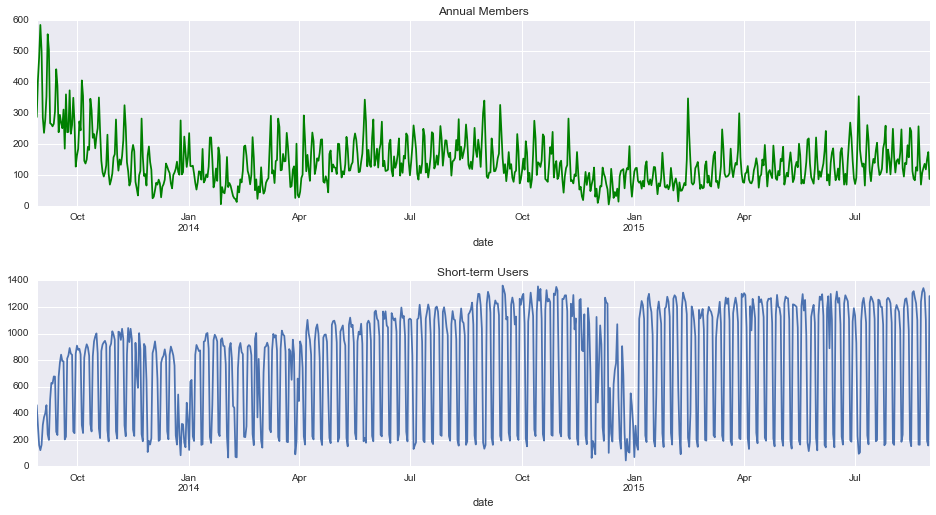

In [16]:
fig, ax = plt.subplots(2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.4)
by_date.iloc[:, 0].plot(ax=ax[0], title='Annual Members', color='green');
by_date.iloc[:, 1].plot(ax=ax[1], title='Short-term Users');

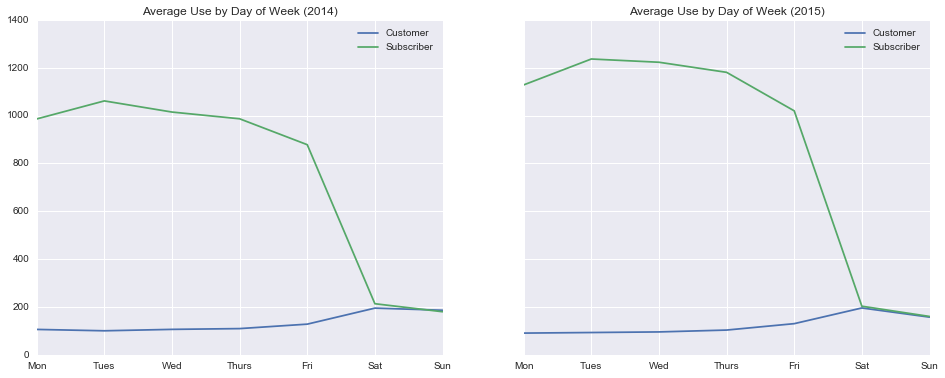

In [8]:
by_weekday = by_date.groupby([by_date.index.year,
                              by_date.index.dayofweek]).mean()
by_weekday.columns.name = None  # remove label for plot

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
by_weekday.loc[2014].plot(title='Average Use by Day of Week (2014)', ax=ax[0]);
by_weekday.loc[2015].plot(title='Average Use by Day of Week (2015)', ax=ax[1]);
for axi in ax:
    axi.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])

In [9]:
# count trips by date and by hour
by_hour = trips.pivot_table('Trip ID', aggfunc='count',
                            index=['date', 'hour'],
                            columns='Subscription Type').fillna(0).reset_index('hour')

# average these counts by weekend
by_hour['weekend'] = (by_hour.index.dayofweek >= 5)
by_hour = by_hour.groupby(['weekend', 'hour']).mean()
by_hour.index.set_levels([['weekday', 'weekend'],
                          ["{0}:00".format(i) for i in range(24)]],
                         inplace=True);
by_hour.columns.name = None

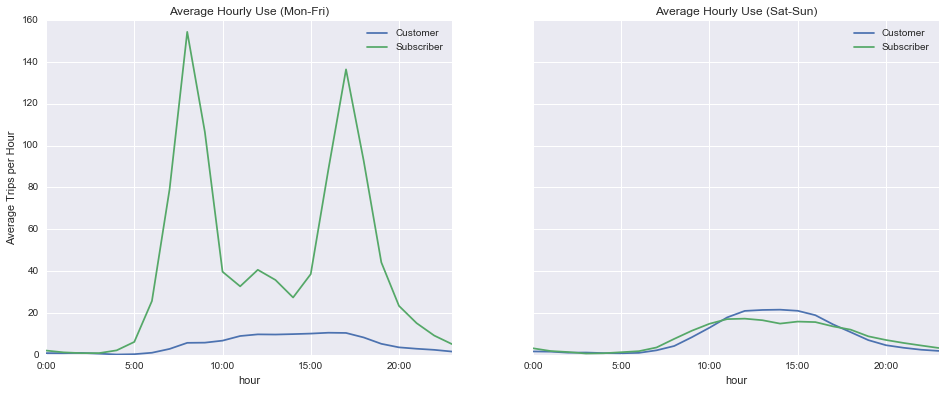

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
by_hour.loc['weekday'].plot(title='Average Hourly Use (Mon-Fri)', ax=ax[0])
by_hour.loc['weekend'].plot(title='Average Hourly Use (Sat-Sun)', ax=ax[1])
ax[0].set_ylabel('Average Trips per Hour');

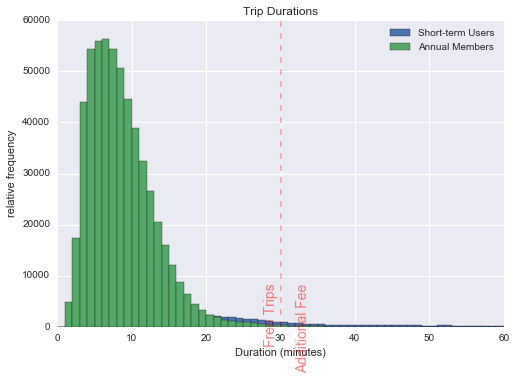

In [48]:
trips['minutes'] = trips['Duration'] /60
# trips['log_minutes'] = trips.minutes.apply(lambda x: np.log(x))
trips.groupby('Subscription Type')['minutes'].hist(bins=np.arange(61), alpha=0.5, normed=True, Log=True);
plt.xlabel('Duration (minutes)')
plt.ylabel('relative frequency')
plt.title('Trip Durations')
plt.text(34, 0.09, "Free Trips\n\nAdditional Fee", ha='right',size=14, rotation=90, alpha=0.5, color='red')
plt.legend(['Short-term Users', 'Annual Members'])

plt.axvline(30, linestyle='--', color='red', alpha=0.3);

###Estimating Trip Distances

In [23]:
stations = pd.read_csv('DATA/babs_open_data_year_1/201402_babs_open_data/201402_station_data.csv')
pronto_shop = dict(id=54, name="Pronto shop",
                   terminal="Pronto shop",
                   lat=47.6173156, long=-122.3414776,
                   dockcount=100, online='10/13/2014')
stations = stations.append(pronto_shop, ignore_index=True)

In [ ]:
from time import sleep

def query_distances(stations=stations):
    """Query the Google API for bicycling distances"""
    latlon_list = ['{0},{1}'.format(lat, lng)
                   for (lat, lng) in zip(stations.lat, stations.long)]

    def create_url(i):
        URL = ('https://maps.googleapis.com/maps/api/distancematrix/json?'
               'origins={origins}&destinations={destinations}&mode=bicycling')
        return URL.format(origins=latlon_list[i],
                          destinations='|'.join(latlon_list[i + 1:]))

    for i in range(len(latlon_list) - 1):
        url = create_url(i)
        filename = "distances_{0}.json".format(stations.terminal.iloc[i])
        print(i, filename)
        !curl "{url}" -o {filename}
        sleep(11) # only one query per 10 seconds!


def build_distance_matrix(stations=stations):
    """Build a matrix from the Google API results"""
    dist = np.zeros((len(stations), len(stations)), dtype=float)
    for i, term in enumerate(stations.terminal[:-1]):
        filename = 'queried_distances/distances_{0}.json'.format(term)
        row = json.load(open(filename))
        dist[i, i + 1:] = [el['distance']['value'] for el in row['rows'][0]['elements']]
    dist += dist.T
    distances = pd.DataFrame(dist, index=stations.terminal,
                             columns=stations.terminal)
    distances.to_csv('station_distances.csv')
    return distances

# only call this the first time
import os
if not os.path.exists('station_distances.csv'):
    # Note: you can call this function at most ~twice per day!
    query_distances()

    # Move all the queried files into a directory
    # so we don't accidentally overwrite them
    if not os.path.exists('queried_distances'):
        os.makedirs('queried_distances')
    !mv distances_*.json queried_distances

    # Build distance matrix and save to CSV
    distances = build_distance_matrix()

In [ ]:
distances = pd.read_csv('station_distances.csv', index_col='terminal')
distances.iloc[:5, :5]

In [ ]:
stacked = distances.stack() / 1609.34  # convert meters to miles
stacked.name = 'distance'
trips = trips.join(stacked, on=['from_station_id', 'to_station_id'])

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
trips.groupby('Subscription Type')['distance'].hist(bins=np.linspace(0, 6.99, 50),
                                           alpha=0.5, ax=ax);
plt.xlabel('Distance between start & end (miles)')
plt.ylabel('relative frequency')
plt.title('Minimum Distance of Trip')
plt.legend(['Annual Members', 'Short-term Pass']);

### Rider Speed

In [ ]:
trips['speed'] = trips.distance * 60 / trips.minutes
trips.groupby('Subscription Type')['speed'].hist(bins=np.linspace(0, 15, 50), alpha=0.5, normed=True);
plt.xlabel('lower bound riding speed (MPH)')
plt.ylabel('relative frequency')
plt.title('Rider Speed Lower Bound (MPH)')
plt.legend(['Annual Members', 'Short-term Pass']);
